# **UK Biobank sample analysis**
___

## 1. UK Biobank supplies us with an encrypted dataset along with few scripts that can be downloded [here](https://biobank.ctsu.ox.ac.uk/crystal/download.cgi).

### ---> Before using the following UKBB scipts, please make sure you are on a system with **150GB RAM** & **100GB free space**. 
### ---> UKBB data is really large!

#### 1.1 UKBB encodes the data first and then encrypts it. That means, we will have to first decrypt it, and then decode it. 

#### 1.2 We decypt the data using: **ukb_unpack ukbxxxx.enc < Your UKBB Key >** 
+ *ukb_unpack* can be found on the link above for Linux/Win systems and will produce a .enc_ukbb file which will be around **~16GB**

#### 1.3 The above command will produce **ukbxxxx.enc_ukb** file, that can be decoded to a TAB seperated TSV using: **ukb_conv ukbxxxx.enc_ukb r**
+ The TAB file produced will be around **~34GB**.

#### 1.4 This will finally create a TSV file called **ukbxxxx.tab** and an R script **ukbxxxx.r**. This R file reads the data for us easily.

#### 1.5 You can also check [this github.io link](https://kenhanscombe.github.io/ukbtools/articles/explore-ukb-data.html#making-a-key-1) for more information regarding this section

___
___

## 2. We can use R to save the datasetin the [FST data format](https://www.fstpackage.org/) to save the data fast & efficiently.

In [ ]:
install.packages("fst")

In [55]:
library(fst)
library(dplyr)
library(ggplot2)

In [ ]:
source("ukbxxxx.r")
library(fst)
threads_fst(nr_of_threads = 30)

#bd is the object created by the R script sourced in the first line.
write.fst(bd, "ukb_full_data.fst")

### After this section, you will have a file: **ukb_full_data.fst**, which will be around **13GB**

___
___

## 3. Now we have the dataset saved in FST format that we can directly read through R.

In [38]:
df <- read_fst("../xxxx/<YourPath>/xxxx/ukb_full_data.fst") 

In [39]:
#Let's look at number of rows & number of columns
dim(df)

[1] 502486  18093

#### 3.1 We can see, our dataset has ~502k rows (participants) and ~18k (columns/fields).

___
___

## 4. Let's have a look at the data in UKBB from ethnic group point-of-view.

#### 4.1 From the [UKBB Website](https://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=21000) we know that EthnicGroup is stored in field 21000. So let's see what fields have that number.

In [40]:
grep("21000", names(df), value=TRUE)

[1] "f.21000.0.0" "f.21000.1.0" "f.21000.2.0"

In [41]:
head(df[c("f.21000.0.0", "f.21000.1.0", "f.21000.2.0")])

,f.21000.0.0,f.21000.1.0,f.21000.2.0
,<ord>,<ord>,<ord>
1,British,NA,NA
2,Any other Asian background,NA,NA
3,British,NA,NA
4,British,NA,NA
5,British,NA,NA
6,British,NA,NA


In [42]:
head(unique(df[c("f.21000.0.0")]))

,f.21000.0.0
,<ord>
1,British
2,Any other Asian background
14,Chinese
16,Other ethnic group
30,Pakistani
37,Irish


#### 4.2 But the column name: **f.21000.0.0** only has the information for EthnicBackground. EthnicBackgroud is a field within EthnicGroup, so we'll have to extract that information.

#### 4.3 Let's create a column which has the EthicGroup categories: White, Black, Mixed, Other, Chinese, or Asian.

#### 4.4 EthnicGroup will be inferred using the following categorizations:
+ White <- (British, Irish, Any other white background, White)
+ Black <- (Caribbean, African, Any other Black background)
+ Asian <- (Indian, Pakistani, Bangladeshi, Any other Asian background)
+ Chinese <- (Chinese)
+ Mixed <- (White and Black Caribbean, White and Black African, White and Asian, Any other mixed background)
+ Other <- (Other ethnic group )

In [43]:
df$EthnicGroup = "None"
df$EthnicGroup[df$'f.21000.0.0' %in% c ("British", "Irish", "Any other white background", "White")] = "White"
df$EthnicGroup[df$'f.21000.0.0' %in% c ("Caribbean", "African", "Any other Black background")] = "Black"
df$EthnicGroup[df$'f.21000.0.0' %in% c ("Indian", "Pakistani", "Bangladeshi", "Any other Asian background")] = "Asian"
df$EthnicGroup[df$'f.21000.0.0' %in% c ("White and Black Caribbean", "White and Black African", "White and Asian", "Any other mixed background")] = "Mixed"
df$EthnicGroup[df$'f.21000.0.0' %in% c ("Chinese")] = "Chinese"
df$EthnicGroup[df$'f.21000.0.0' %in% c ("Other ethnic group")] = "Other"

#Remove individuals which are not in any of the above categories.
df = df[df$EthnicGroup != "None", ]

#### 4.5 Now we have saved EthnicGroup for individuals in the EthnicGroup column name.

In [44]:
df %>% count(EthnicGroup)

EthnicGroup,n
<chr>,<int>
Asian,9838
Black,8034
Chinese,1574
Mixed,2909
Other,4558
White,472677


___
___

# 5. Now let's look at the biomarker: [Urea field 30670](https://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=30670).

#### 5.1 Let's look at this (30670 <-> Urea) column number:

In [46]:
head(unique(df[c("f.30670.0.0")]))

,f.30670.0.0
,<dbl>
1,5.46
2,NA
3,4.84
4,3.37
6,4.50
7,3.90


#### 5.2 Let's remove the NAs and plot a graph to visualize the biomarker levels.

In [81]:
#Create a new df just for UREA levels.
for_urea_df = df[c("EthnicGroup", "f.30670.0.0", "f.31.0.0")]
head(for_urea_df)

#Sample only 10,000 White individuals.
sub_sampled_for_urea_df = rbind(for_urea_df[for_urea_df$EthnicGroup != "White", ], for_urea_df[for_urea_df$EthnicGroup == "White", ] %>% sample_n(10000))

#Let's remove the NA values.
nrow(sub_sampled_for_urea_df)
sub_sampled_for_urea_df = sub_sampled_for_urea_df[!is.na(sub_sampled_for_urea_df$"f.30670.0.0"), ]
sub_sampled_for_urea_df = sub_sampled_for_urea_df[!is.na(sub_sampled_for_urea_df$"f.31.0.0"), ]
nrow(sub_sampled_for_urea_df)

,EthnicGroup,f.30670.0.0,f.31.0.0
,<chr>,<dbl>,<ord>
1,White,5.46,Male
2,Asian,NA,Male
3,White,4.84,Female
4,White,3.37,Female
5,White,NA,Female
6,White,4.50,Male


[1] 36913

[1] 34025

In [84]:
colnames(sub_sampled_for_urea_df)[2] <- "UreaLevels"
colnames(sub_sampled_for_urea_df)[3] <- "Sex"
head(sub_sampled_for_urea_df)

,EthnicGroup,UreaLevels,Sex
,<chr>,<dbl>,<ord>
16,Other,3.61,Male
30,Asian,4.14,Female
51,Mixed,8.58,Male
56,Other,3.53,Female
68,Asian,4.70,Male
76,Mixed,4.09,Female


#### 5.3 Let's plot a box plot for UREA levels by EthnicGroup.

Warning message:
“Removed 219 rows containing non-finite values (stat_boxplot).”


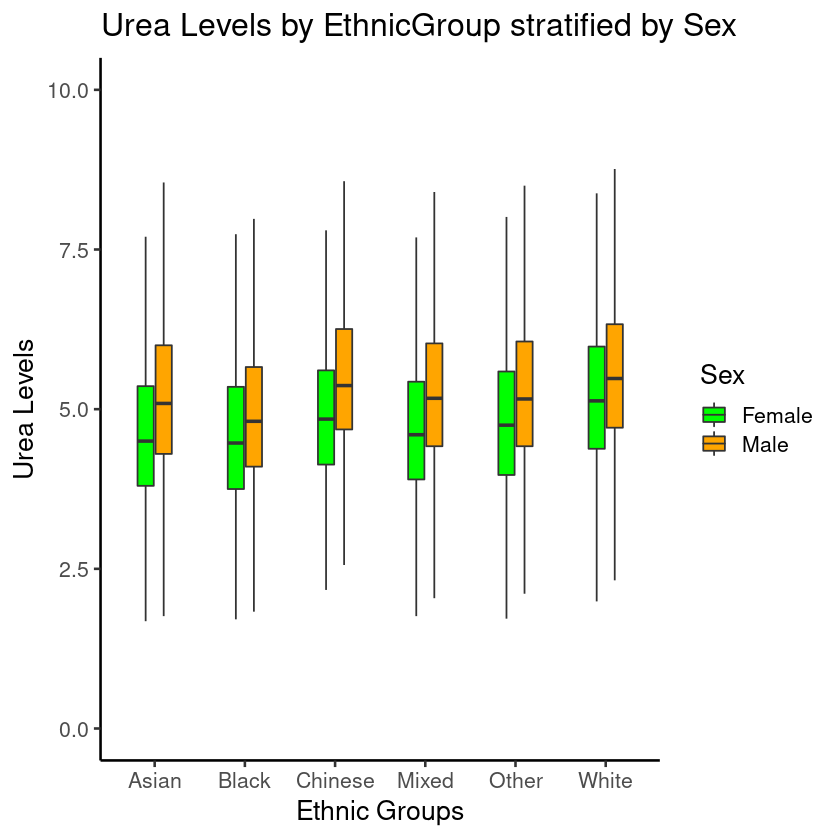

In [91]:
ggplot(sub_sampled_for_urea_df, aes(x=EthnicGroup, y=UreaLevels, fill=Sex)) + 
    geom_boxplot(outlier.shape=NA, width=0.4) + scale_fill_manual(values = c("green", "orange")) + 
    labs(x="Ethnic Groups", y="Urea Levels", title = "Urea Levels by EthnicGroup stratified by Sex",) + 
    theme_classic(base_size = 16) + ylim(c(0,10))

#### 5.4 Let's also look at mean Urea levels by Ethnicity and Sex

In [92]:
aggregate(UreaLevels ~ EthnicGroup + Sex, data = sub_sampled_for_urea_df, FUN= "mean")

EthnicGroup,Sex,UreaLevels
<chr>,<ord>,<dbl>
Asian,Female,4.668929
Black,Female,4.675777
Chinese,Female,4.964417
Mixed,Female,4.772416
Other,Female,4.881406
White,Female,5.268508
Asian,Male,5.289017
Black,Male,5.029648
Chinese,Male,5.519556


# End of Notebook!

___
___